# 1. Función para convertir a escala de grises y reescalar la imagen

In [ ]:
!pip install opencv-python-headless numpy

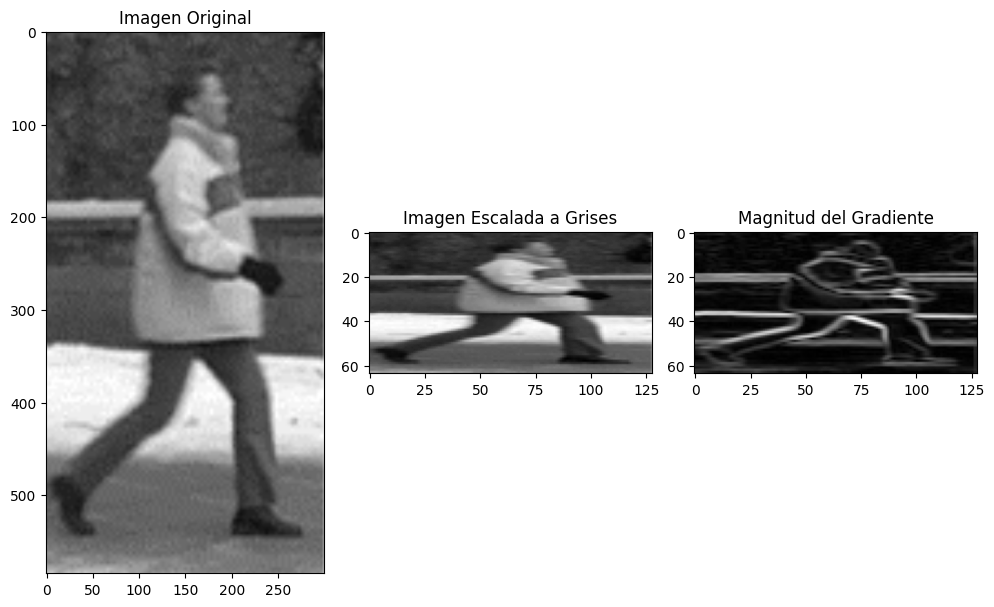

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def convert_and_resize(image, scale):
    # Asegúrate de que 'scale' sea al menos 1.
    assert scale >= 1, "El parámetro de escala 'k' debe ser al menos 1."
    
    # Conversión de RGB a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Reescalado de la imagen a (128k, 64k)
    resized_image = cv2.resize(gray_image, (128 * scale, 64 * scale), interpolation=cv2.INTER_AREA)
    
    return resized_image.astype(np.float32)  # Asegura que la salida sea float32

def gradient_magnitude_and_angle(image):
    # Filtros de Prewitt
    Gx_kernel = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=np.float32)
    Gy_kernel = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float32)
    
    # Aplicación de padding para mantener el tamaño original de la imagen
    padded_image = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
    
    # Correlación con los filtros de Prewitt
    Gx = cv2.filter2D(padded_image, -1, Gx_kernel)
    Gy = cv2.filter2D(padded_image, -1, Gy_kernel)
    
    # Cálculo de la magnitud y el ángulo del gradiente
    magnitude = np.sqrt(Gx**2 + Gy**2)
    angle = (np.arctan2(-Gy, Gx) * (180 / np.pi)) % 180  # Convertir a grados y aplicar módulo 180
    
    # Remover el padding
    magnitude = magnitude[1:-1, 1:-1]
    angle = angle[1:-1, 1:-1]
    
    return magnitude, angle

# Ejemplo de uso
# Cargar una imagen (ajusta la ruta según sea necesario)
image_path = 'person.png'  # Asegúrate de cambiar esto a la ruta de tu imagen
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB para visualización correcta

# Convertir y reescalar
scale = 1  # Ajusta este valor según necesites
resized_image = convert_and_resize(image, scale)

# Calcular magnitud y ángulo del gradiente
magnitude, angle = gradient_magnitude_and_angle(resized_image)

# Visualizar
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Imagen Original')

plt.subplot(1, 3, 2)
plt.imshow(resized_image, cmap='gray')
plt.title('Imagen Escalada a Grises')

plt.subplot(1, 3, 3)
plt.imshow(magnitude, cmap='gray')
plt.title('Magnitud del Gradiente')

plt.tight_layout()
plt.show()
